In [1]:
# 1. 환경 준비

import autorootcwd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from src.padain_synthesis import PadainSynthesisPipeline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # 특정 GPU 사용

/home/milab/anaconda3/envs/danny_natten/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Pipeline 로드 (from_pretrained)

checkpoint_path = "./weights/padain_synthesis/padain_synthesis_experiment/20250724_171213/checkpoint-79"
pipe = PadainSynthesisPipeline.from_pretrained(checkpoint_path, device='cuda')

In [3]:
# 3. 단일 슬라이스 inference

import nibabel as nib
import numpy as np

ct_nii = nib.load('data/synthrad2023_mr-ct_pelvis/1PA154/1PA154_real_a.nii.gz')
cbct_nii = nib.load('data/synthrad2023_mr-ct_pelvis/1PA154/1PA154_real_b.nii.gz')

ct_arr = ct_nii.get_fdata()
cbct_arr = cbct_nii.get_fdata()

# 3D 볼륨 전체 정규화
ct_arr = (ct_arr - ct_arr.min()) / (ct_arr.max() - ct_arr.min())
ct_arr = ct_arr * 2 - 1
cbct_arr = (cbct_arr - cbct_arr.min()) / (cbct_arr.max() - cbct_arr.min())
cbct_arr = cbct_arr * 2 - 1

print('원본 shape:', ct_arr.shape, cbct_arr.shape)  # (384, 320, 79)

slice_idx = 0
input_slice = ct_arr[..., slice_idx]  # (384, 320)
reference_slice = cbct_arr[..., slice_idx]  # (384, 320)

input_slice = input_slice[None, ...].astype(np.float32)  # (1, 384, 320)
reference_slice = reference_slice[None, ...].astype(np.float32)  # (1, 384, 320)

output_slice = pipe(input=input_slice, reference=reference_slice)

원본 shape: (384, 320, 79) (384, 320, 79)
[pipeline.py] merged_input shape: torch.Size([1, 2, 384, 320])
[pipeline.py] output shape: (1, 384, 320)


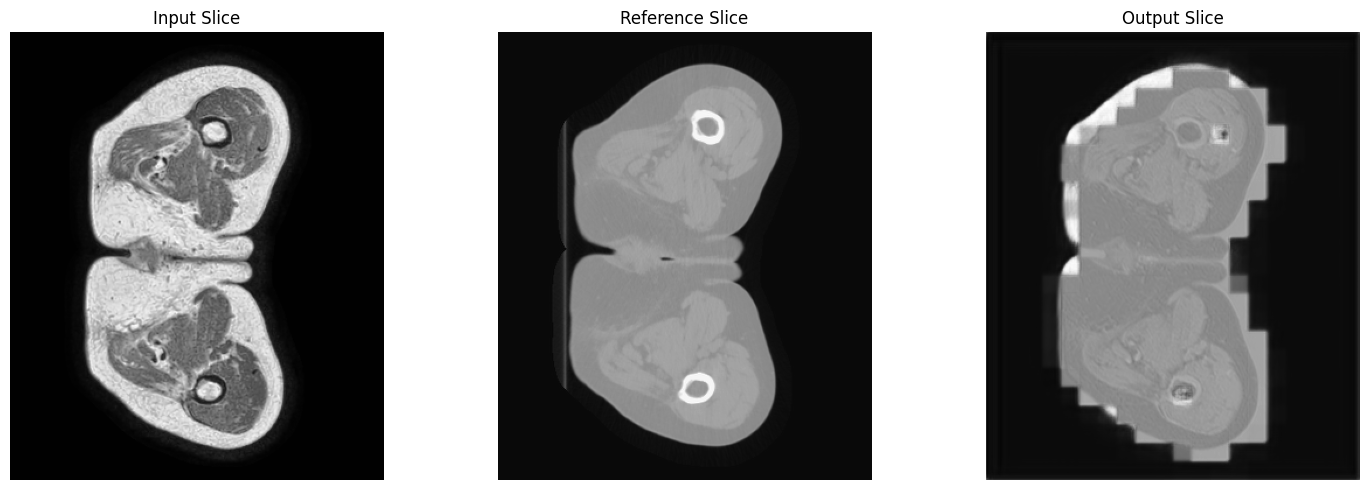

In [4]:
# 4. 결과 시각화

# (1, H, W) -> (H, W)로 변환
input_img = input_slice[0]
reference_img = reference_slice[0]
output_img = output_slice[0] if output_slice.ndim == 3 else output_slice  # (1, H, W) or (H, W)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(input_img, cmap='gray')
axes[0].set_title('Input Slice')
axes[0].axis('off')

axes[1].imshow(reference_img, cmap='gray')
axes[1].set_title('Reference Slice')
axes[1].axis('off')

axes[2].imshow(output_img, cmap='gray')
axes[2].set_title('Output Slice')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# pip install aura-sr

Note: you may need to restart the kernel to use updated packages.


In [1]:
from aura_sr import AuraSR

aura_sr = AuraSR.from_pretrained("fal/AuraSR-v2")

import requests
from io import BytesIO
from PIL import Image

def load_image_from_url(url):
    response = requests.get(url)
    image_data = BytesIO(response.content)
    return Image.open(image_data)

image = load_image_from_url("https://mingukkang.github.io/GigaGAN/static/images/iguana_output.jpg").resize((256, 256))
upscaled_image = aura_sr.upscale_4x_overlapped(image)

/home/milab/anaconda3/envs/danny_natten/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 6 files: 100%|██████████| 6/6 [01:33<00:00, 15.54s/it]


Original image size: (256, 256)
Upscaled image size: (1024, 1024)


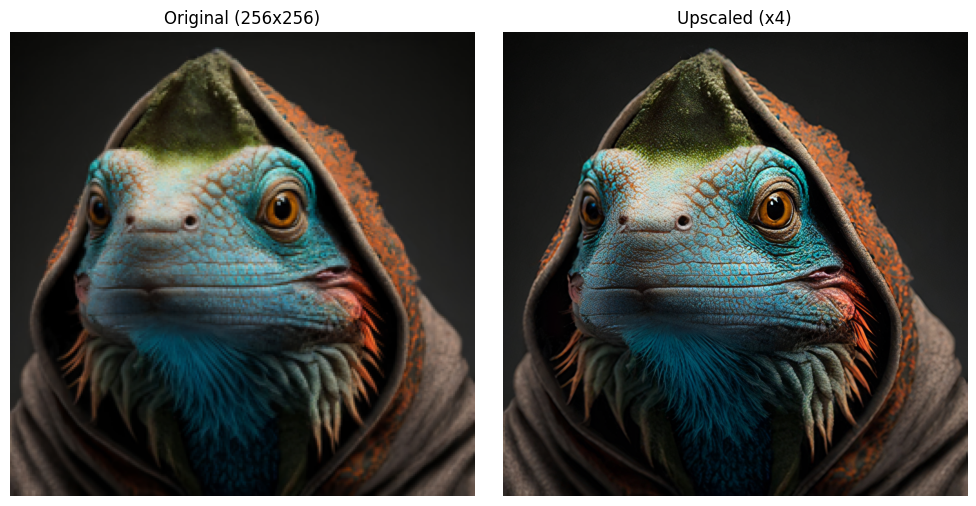

In [2]:
import matplotlib.pyplot as plt

# 이미지 크기 확인
print("Original image size:", image.size)            # (width, height)
print("Upscaled image size:", upscaled_image.size)    # (width, height)

# 이미지 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original (256x256)")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Upscaled (x4)")
plt.imshow(upscaled_image)
plt.axis("off")

plt.tight_layout()
plt.show()
